# Normals and other local descriptors

This notebook tackles the computation of normals and other local descriptors, which provide **additional information about the underlying surface geometry around each point**. These local descriptors play a crucial role in various tasks such as rendering, surface reconstruction, segmentation, and classification. The quality of their estimation greatly impacts the quality and reliability of subsequent processing steps.

In this notebook, we will delve into the methods and techniques for computing normals and local descriptors. The emphasis placed on calculating normals is the result of their widespread use in point cloud processing. We will explore various algorithms, discuss their strengths and limitations, and provide practical examples to illustrate their application.

In [1]:
# Necessary imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import KDTree, Delaunay
from scipy.sparse import dok_matrix
from scipy.sparse.csgraph import minimum_spanning_tree, breadth_first_order

# Load example pointcloud
data = np.loadtxt("./data/stanford_bunny_custom.xyz")
points = data[:, :3]
ground_truth_normals = data[:, 3:6]

## Normals

**A normal is a vector associated with each point of a pointcloud and perpendicular to the underlying surface it samples**. The convention is that the normal **points outward from the surface**. In some cases, normals are calculated directly during the acquisition process. In most cases, they must be computed afterwards, which is what is considered here.

The most common technique for calculating normals is based on the *tangent plane estimation*, which simply involves **approximating the underlying surface around each point by a plane**. In practice, a plane is fitted to the set of points consisting of the point of interest and its closest neighbors. The normal to the point is approximated by the normal to the fitted plane. This approach was described in the paper:

Hoppe, H., et al. (1992, July). Surface reconstruction from unorganized points. In *Proceedings of the 19th annual conference on computer graphics and interactive techniques* (pp. 71-78).

It may be summarized in a few steps.

For each point $p_i$ of the pointcloud:
1. Query the $k$-nearest neighbors of $p_i$ and add them to a set $N_b(p_i)$ also containing $p_i$.
2. Compute the inertia matrix $I_{i}$ from this set.
3. Decompose the inertia matrix $I_i$ into eigenvalues $(\lambda_1, \lambda_2, \lambda_3)$ and eigenvectors $(\nu_1, \nu_2, \nu_3)$.
4. Select **the normal as the eigenvector associated with the smallest eigenvalue**, or to put it simply: $n_i \pm \nu_3$.

As a reminder (see last chapter on primitive fitting for more details), the inertia matrix of the neighbors is given by $I_i = \sum_{p_{j} \in N_b(p_{i})} (p_j - c_i) \cdot (p_j - c_i)^{T}$ with $c_{i}$ the center of mass of the set of neighbors $N_b(p_i)$, given by $c_{i} = \frac{1}{k+1} \sum_{p_{j} \in N_b(p_{i})} p_j$. The fitting process is here considered in the sense of least squares, and the fitting error is given directly by $\lambda_3$.

Let's see the result on our *Stanford Bunny*!

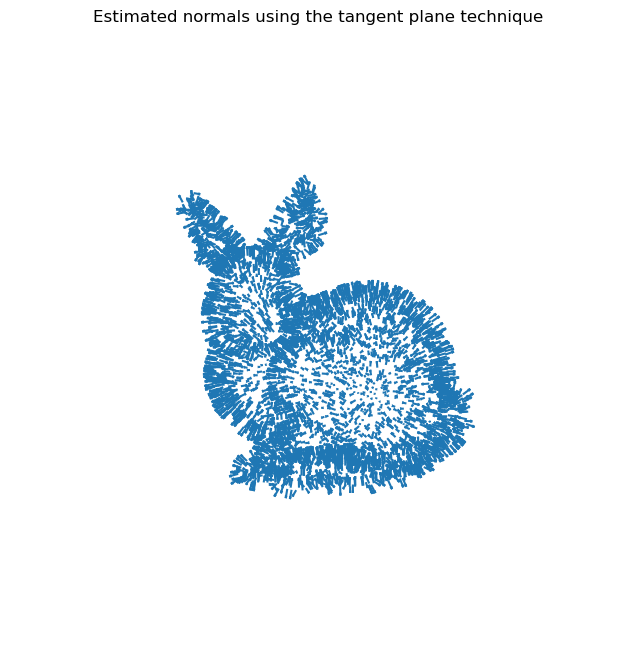

In [2]:
def compute_normals(points, neighbor_finding_function):
    
    # Initialize an array to hold the normals
    normals = np.zeros(points.shape)
    
    for i, point in enumerate(points):
        # Find the k nearest neighbors
        indices = neighbor_finding_function(point)
        # Get the neighbors
        neighbors = points[indices]
        # Compute the covariance matrix
        cov_matrix = np.cov(neighbors.T)
        # Compute the eigenvalues and eigenvectors
        _, eigenvectors = np.linalg.eigh(cov_matrix)
        # The normal is the eigenvector corresponding to the smallest eigenvalue
        normals[i] = eigenvectors[:, 0]
    
    return normals


# Build KDTree for neighbor search
kdtree = KDTree(points)
# Define neighbor finding function using KDTree
def neighbor_finding_function(point): return kdtree.query(point, k=10)[1]
# Compute normals
normals = compute_normals(points, neighbor_finding_function)

# Visualize the point cloud and normals
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
ax.quiver(points[:, 0], points[:, 1], points[:, 2],
        5.*normals[:, 0], 5.*normals[:, 1], 5.*normals[:, 2]) # we make normals a little bit larger for visualization purposes
ax.view_init(10, 60)
ax.set_axis_off()
plt.axis("equal")
plt.title("Estimated normals using the tangent plane technique")
plt.show()


The process of estimating the normals seems to have gone well, and the overall result is quite visually convincing. However, this is not the case when zooming in on certain areas, as can be seen below where the estimated normals are compared with the ground truth normals (derived from the original bunny mesh).


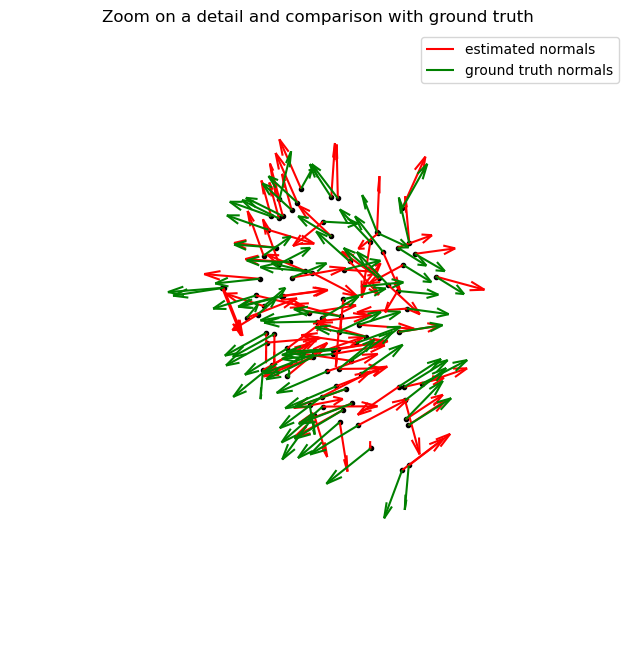

In [3]:
# Zoom on a detail (rabbit ear) and compare with ground truth normals
inds_detail = kdtree.query_ball_point(points[136], r=25.)

# Visualize the sub pointcloud and normals
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
ax.plot(points[inds_detail, 0], points[inds_detail, 1], points[inds_detail, 2], 'k.')
ax.quiver(points[inds_detail, 0], points[inds_detail, 1], points[inds_detail, 2],
        5.*normals[inds_detail, 0], 5.*normals[inds_detail, 1], 5.*normals[inds_detail, 2], # we make normals a little bit larger for visualization purposes
        color="red", label="estimated normals") 
ax.quiver(points[inds_detail, 0], points[inds_detail, 1], points[inds_detail, 2],
        5.*ground_truth_normals[inds_detail, 0], 5.*ground_truth_normals[inds_detail, 1], 5.*ground_truth_normals[inds_detail, 2], # we make normals a little bit larger for visualization purposes
        color="green", label="ground truth normals")
ax.view_init(0, 0)
ax.set_axis_off()
ax.legend()
plt.axis("equal")
plt.title("Zoom on a detail and comparison with ground truth")
plt.show()

One source of error can be attributed to the *tangent plane approximation* itself, which degree of validity depends on the considered scale. In practical terms, the choice of the type and size of the neighborhood plays significant role in normal computation. Indeed, small neighborhoods better capture the underlying local surface around a point but makes the best-fit plane computation sensitive to noise. On the other hand, large neighborhoods are less likely to capture the surface variation around the point but tend to reduce the contribution of noise in the computation of the best-fit plane. Moreover, this trade-off applies to each individual point, based on local pointcloud density and noise.

The residual of the best-fitted plane, given by the smallest eigenvalue $\lambda_3$, is a good indicator to assess the locally-plane surface hypothesis (see last notebook on primitive fitting). Its value may for example be compared to acquisition noise or to other values obtained with different neighborhoods. Another option is to use metric to assess that the tangent plane hypothesis is verified. Once again, eigenvalues may be put to good use. The tangent plane hypothesis is verified if $\lambda_1 \geq \lambda_2 >> \lambda_3$. So, in practice, the ratio between the smallest eigenvalue and the others may be a suitable indicator to choose the appropriate type and size of neighborhood to compute normals:
\begin{equation*}
r = \frac{\lambda_3}{\lambda_1 + \lambda_2}
\end{equation*}

The rule of thumb is that the denser the pointcloud, the larger the number of neighbors $k$ (knn search) or the radius $r$ (ball search) used to compute the tangent plane. Usually, a value of $k=10$ is a good starting point. It may then be refined for the whole pointcloud or specific zones of it.

Below are some results obtained for our bunny. As expected, the tangent plane hypothesis is least verified for the zone of high surface variation such as the ears of the rabbit. A small $k$ value is better suited for a small pointcloud such as this one.

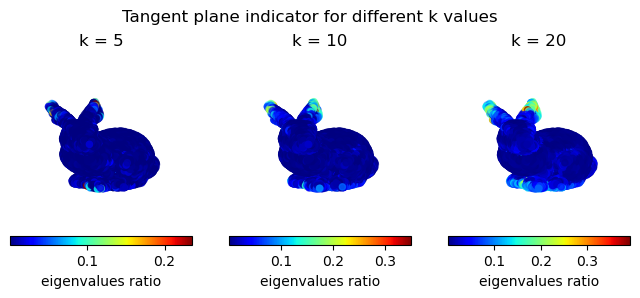

In [4]:
def compute_normals_with_ratio(points, neighbor_finding_function):
    
    # Initialize an array to hold the normals
    normals = np.zeros(points.shape)
    ratio = np.zeros(points.shape[0])
    
    for i, point in enumerate(points):
        # Find the k nearest neighbors
        indices = neighbor_finding_function(point)
        # Get the neighbors
        neighbors = points[indices]
        # Compute the covariance matrix
        cov_matrix = np.cov(neighbors.T)
        # Compute the eigenvalues and eigenvectors
        eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
        # The normal is the eigenvector corresponding to the smallest eigenvalue
        normals[i] = eigenvectors[:, 0]
        # Compute the ratio of the smallest eigenvalue to the sum of the other two
        ratio[i] = eigenvalues[0] / (eigenvalues[1] + eigenvalues[2])
    
    return normals, ratio


# Compute normals and ratio for different k values
k_neighbors = [5, 10, 20]
ratios = []
for k in k_neighbors:
    # Define neighbor finding function using KDTree
    def neighbor_finding_function(point, k=k): return kdtree.query(point, k=k)[1]
    # Compute normals and ratio
    _, ratio = compute_normals_with_ratio(points, neighbor_finding_function)
    ratios.append(ratio)

# Visualize the ratio for different k values
fig = plt.figure(figsize=(8, 3))
for i, ratio in enumerate(ratios):
    ax = fig.add_subplot(1, len(ratios), i+1, projection="3d")
    im = ax.scatter(points[:, 0], points[:, 1], points[:, 2], c=ratio, cmap='jet')
    cbar = fig.colorbar(im, ax=ax, location="bottom", orientation="horizontal", pad=0)
    cbar.set_label('eigenvalues ratio')
    ax.set_title(f"k = {k_neighbors[i]}")
    ax.view_init(10, 60)
    ax.set_axis_off()
plt.suptitle("Tangent plane indicator for different k values")
plt.show()

Another source of error is attributed to the lack of *consistent orientation* between the estimated tangent planes. Indeed, the local plane approximation described above does not guarantee that all computed normals point outward from the surfaces describing our bunny. Some may instead point to the opposite direction (i.e., inward), as illustrated above.

To solve this, the authors of the paper cited above consider that the pointcloud is sufficiently dense and the underlying surface sufficiently smooth so that **tangent planes computed for two close points $p_i$ and $p_j$ are nearly parallel**. Therefore, the following criterion for orientation consistency is defined: **if $n_i \cdot n_j \approx 1$ then normals are consistently aligned**. If not $n_i \cdot n_j \approx - 1$ and one of them should be flipped. The next step is to find pairs of "close" points with nearly parallel tangent planes along which to check for validity and make corrections if necessary. This is done by **finding a path through neighboring points minimizing variation between normals, thanks to elements of graph theory**. More precisely, this path is the *minimum spanning tree* of the *Riemannian Graph*, which edges connect close points and are weighted according to the angle between unoriented normals. Finally, a starting point is selected and the graph is traversed, flipping normals when necessary.

Consistent tangent plane orientation is computed as follows:

1. Compute the Euclidean Minimum Spanning Tree (EMST) or the shortest path (distance) connecting all points. 
2. Compute the $k$-nearest neighbors graph (KNN), connecting each point to its $k$ nearest neighbors.
3. Fuse the EMST and KNN graphs into the *Riemannian Graph*.
4. Replace/compute the weights associated with edges of the *Riemannian Graph* such as $e_{ij} = 1 - |n_i \cdot n_j|$.
5. Extract the minimum spanning tree of the *Riemannian Graph*.
6. Choose an initial point and orientation, for example select the point with the highest $z$ coordinate and make it pointing towards $+z$ (so that $n_0 \cdot e_z > 0$).
7. Traverse the graph, flipping the normal associated with the current point if necessary.

Note that the EMST described above happens to be a subgraph of the Delaunay triangulation, so computing the Delaunay Triangulation is an efficient way to get the EMST.

The implementation proposed below mostly relies on ```scipy``` routines for the "heavy lifting" (i.e., neirest neighbors search, Delaunay triangulation, minimum spanning tree and tree traversal). Graphs are represented as 2D sparse matrices (for more efficient memory management) with a value in position $(i, j)$ denoting an edge $e_{ij}$ between vertices $v_i$ and $v_j$ associated with a weight given by this value.

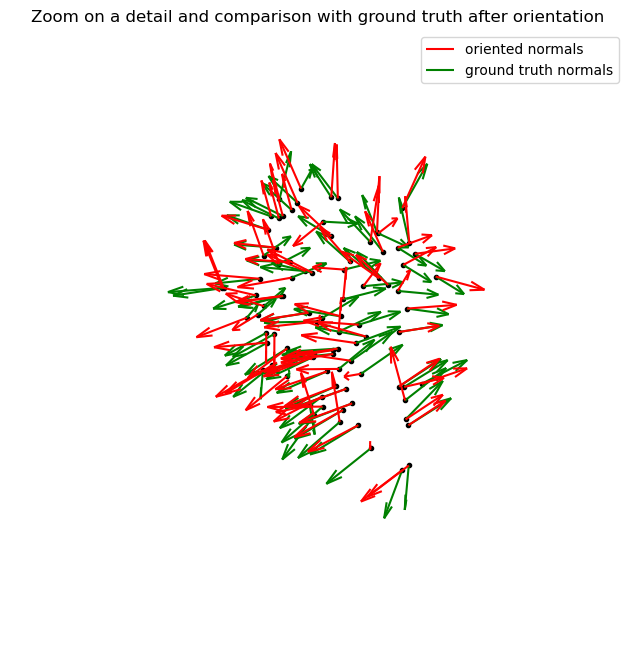

In [5]:
def orient_normals(points, normals, k):
    """Orient normals using a Riemannian Minimum Spanning Tree (RMST) approach."""
    
    normals = normals.copy()
    
    # Create graph (adjacency matrix)
    n_points = len(points)
    riemannian_graph = dok_matrix((n_points, n_points), dtype=np.float32)

    # Compute the Euclidean graph using Delaunay triangulation
    tri = Delaunay(points)
    indptr, indices = tri.vertex_neighbor_vertices
    for i in range(n_points) :
        neighbors = indices[indptr[i]:indptr[i+1]]
        dists = np.linalg.norm(points[i] - points[neighbors], axis=1)
        riemannian_graph[k, neighbors] = dists
    
    # Compute the minimum spanning tree of the Euclidean graph (EMST)
    riemannian_graph = minimum_spanning_tree(riemannian_graph, overwrite=True)
    riemannian_graph = riemannian_graph.todok() # Convert back to DOK format for faster manipulation

    # Add k-nearest neighbors to the EMST to get a denser graph called the Riemannian graph
    _, neighbors = kdtree.query(points, k+1) # k+1 because the point itself is included
    neighbors = neighbors[:, 1:] # Remove the point itself
    for i, nbrs in enumerate(neighbors):
        riemannian_graph[i, nbrs] = 1.

    # Weight the edges of the Riemannian graph according to normal similarity
    for (i, j) in riemannian_graph.keys():
        riemannian_graph[i, j] = 1 - np.abs(normals[i] @ normals[j]) + 1e-6

    # Compute the minimum spanning tree of the Reimannian graph
    riemannian_graph = minimum_spanning_tree(riemannian_graph, overwrite=True)

    # Choose the point with the highest z-coordinate as the root and orient its normal upwards
    root_index = np.argmax(points[:, 2])
    if normals[root_index] @ np.array([0, 0, 1]) < 0:
        normals[root_index] *= -1

    # Propagate normals through the MST
    node_array, predecessors = breadth_first_order(riemannian_graph, root_index, directed=False, return_predecessors=True)
    node_array = node_array[1:] # Exclude the root node from processing
    for current in node_array:
        previous = predecessors[current]
        # Ensure normal consistency
        if normals[current] @ normals[previous] < 0:
            normals[current] *= -1 

    return normals


# Orient normals
# here a low k value is adapted given the density of the point cloud
oriented_normals = orient_normals(points, normals, k=5)

# Visualize the point cloud and normals after orientation
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
ax.plot(points[inds_detail, 0], points[inds_detail, 1], points[inds_detail, 2], 'k.')
ax.quiver(points[inds_detail, 0], points[inds_detail, 1], points[inds_detail, 2],
        5.*oriented_normals[inds_detail, 0], 5.*oriented_normals[inds_detail, 1], 5.*oriented_normals[inds_detail, 2], # we make normals a little bit larger for visualization purposes
        color="red", label="oriented normals") 
ax.quiver(points[inds_detail, 0], points[inds_detail, 1], points[inds_detail, 2],
        5.*ground_truth_normals[inds_detail, 0], 5.*ground_truth_normals[inds_detail, 1], 5.*ground_truth_normals[inds_detail, 2], # we make normals a little bit larger for visualization purposes
        color="green", label="ground truth normals")
ax.view_init(0, 0)
ax.set_axis_off()
ax.legend()
plt.axis("equal")
plt.title("Zoom on a detail and comparison with ground truth after orientation")
plt.show()


As seen above and below, the normals are better oriented now but some deviations still remain. 

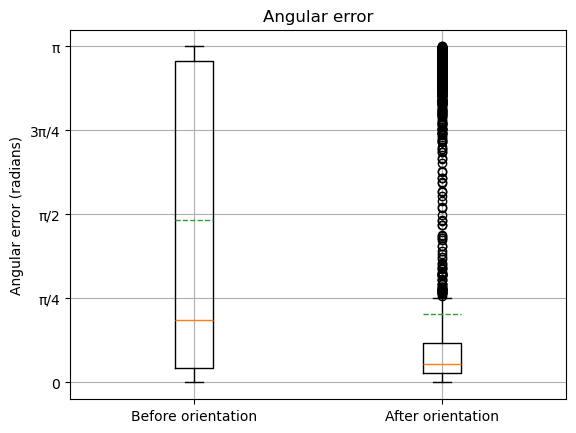

In [ ]:
# Plot angular error between estimated normals and ground truth normals
plt.figure()
plt.boxplot(
    [np.arccos(np.clip(np.sum(n * ground_truth_normals, axis=1), -1.0, 1.0))
    for n in [normals, oriented_normals]], 
    tick_labels=["Before orientation", "After orientation"],
    meanline=True, showmeans=True,
    )
plt.ylabel("Angular error (radians)")
plt.yticks([0., np.pi/4, np.pi/2, 3*np.pi/4, np.pi], ["0", "π/4", "π/2", "3π/4", "π"])
plt.title(f"Angular error")
plt.grid(True)
plt.show()

Although it dates back several decades, the technique described above for calculating and orienting normals is still widely used today (for example in CloudCompare). Despite some limitations due to its initial assumptions, it produces fairly good results while having a relatively short execution time, even for large pointclouds.

Note that many variations of this techniques and other "tricks" have been proposed since then to mitigate some of its limitations and improve its results. The paragraph below lists a few examples.

Let's start with the tangent plane estimation itself. As we have seen previously, this is based primarily on a locally smooth surface assumption that is rarely verified for the whole pointcloud. To overcome this limitation and better capture the surface variation, researchers proposed to fit more complexe surfaces, such as spheres or quadrics, to each point's neighborhood instead of a plane. This comes however with a higher computational cost sensitivity to noise (these surfaces having more parameters than a plane).

Another area for improvements concerns the choice of the type of neighborhood used for planar approximation and orientation propagation. Indeed, $k$-nearest neighborhoods or spherical neighborhoods often retain points belonging to other surfaces in areas of high surface variation. This is the case for our bunny's ears, with points belonging to the inside of the ear and points belonging to the outside of it being very close. This is why the implementation of the ```orient_normals_consistent_tangent_plane``` of the ```open3D``` library propose to use a  pseudo-spheric neighborhood penalizing the distance between a point and the tangent plane such as:
\begin{equation*}
dist(p_j, p_i) = ||p_j - p_i|| + \lambda |(p_j - p_i) \cdot n_i |
\end{equation*}
with $\lambda$ as the penalty weight (if null then it falls back to the regular case for which Euclidean distance is considered). An angular threshold is also proposed, in addition to the distance metric described before, to exclude neighbors based on the direction of the normal vector. However, this requires a good initial approximations of normals.

Finally, other works proposed to overcome the limitations coming from the "close to parallel tangent planes hypothesis" for consistent orientation propagation in high surface variation zones of the pointcloud.


Null curvature to constant curvature

$n'_i = n_i - 2 (e_{ij} \cdot n_i) e_{ij}$ with $e_{ij} = (p_i - p_j)/||p_i - p_j||$


```orient_normals_towards_camera_location```